In [1]:
# mount the google drive on colab platform

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

def load_high_res_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [64, 64])
    # Preprocess high-resolution image as needed (e.g., normalization, etc.)
    imgs = tf.cast(img,dtype = tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return imgs

def create_low_res_image(high_res_image, scale_factor = 2):
    low_res_image = tf.image.convert_image_dtype(high_res_image, tf.uint8) * 255
    low_res_image = tf.image.resize(low_res_image, [64 // scale_factor, 64 // scale_factor], method=tf.image.ResizeMethod.BICUBIC)
    low_res_image = tf.image.convert_image_dtype(low_res_image, tf.float32)
    return low_res_image

def create_train_data_loader(image_folder, batch_size, scale_factor, shuffle=True):
    subfolders = [os.path.join(image_folder, folder) for folder in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, folder))]

    high_res_image_paths = []
    for folder in subfolders:
        high_res_image_paths.extend([os.path.join(folder, file) for file in os.listdir(folder)])


    high_res_image_dataset = tf.data.Dataset.from_tensor_slices(high_res_image_paths)
    #print(high_res_image_dataset)
    high_res_images = high_res_image_dataset.map(load_high_res_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    #low_res_images = []
    #for img in high_res_images:
        #low_res_images.append(create_low_res_image(img.numpy(),scale_factor))

    #for img in high_res_images:
        #print(img.shape)
    low_res_image_dataset = high_res_images.map(create_low_res_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return (high_res_images,low_res_image_dataset)

    #dataset = tf.data.Dataset.zip((low_res_image_dataset, high_res_image_dataset))
    #if shuffle:
        #dataset = dataset.shuffle(buffer_size=len(high_res_image_paths), reshuffle_each_iteration=True)

    #dataset = dataset.batch(batch_size)
    #dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    #return dataset

# Example usage:
image_folder = '/content/drive/MyDrive/Dissertation/DIV2K_train_HR'
batch_size = 1
scale_factor = 2  # Change this according to your desired downscaling factor

train_data_loader = create_train_data_loader(image_folder, batch_size, scale_factor)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Tensor("args_0:0", shape=(64, 64, 3), dtype=float32)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
(hRImages,lRImages) = train_data_loader

In [ ]:
len(hRImages)
hRImagesNp = np.zeros((27000,64,64,3),dtype = np.float32)
lRImagesNp = np.zeros((27000,32,32,3),dtype = np.float32)

for i,x in enumerate(hRImages):
    hRImagesNp[i,:] = x

In [ ]:
for i,x in enumerate(lRImages):
    lRImagesNp[i,:] = x

In [ ]:
from tensorflow.keras import layers, models, losses, optimizers

# Generator (Enhancement Network) for ESRGAN
def make_generator_model(scale_factor):
    # Input: Low-resolution image
    inputs = layers.Input(shape=(None, None, 3))

    # Feature extraction layers
    x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)

    # Residual blocks
    for _ in range(16):
        residual = x
        x = layers.Conv2D(64, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(64, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, residual])

    # Upscaling layer using sub-pixel convolution (PixelShuffle)
    x = layers.Conv2D(256, kernel_size=3, padding='same')(x)
    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, scale_factor))(x)

    # Output: High-resolution image
    outputs = layers.Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')(x)

    return models.Model(inputs, outputs)

# Discriminator for ESRGAN
def make_discriminator_model():
    inputs = layers.Input(shape=(None, None, 3))

    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu')(x)

    x = layers.GlobalAveragePooling2D()(x)  # Flatten the output
    x = layers.Dense(1024, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs, outputs)


# ESRGAN model combining Generator and Discriminator
def make_esrgan_model(scale_factor):
    # Set the trainable property for Discriminator to False
    discriminator = make_discriminator_model()
    discriminator.trainable = False

    # Input: Low-resolution image
    inputs_lr = layers.Input(shape=(None, None, 3))

    # Generate high-resolution image using Generator
    generated_hr = make_generator_model(scale_factor)(inputs_lr)

    # Discriminator evaluates generated HR images
    validity = discriminator(generated_hr)

    return models.Model(inputs_lr, [generated_hr, validity])

# Create an instance of the ESRGAN model
scale_factor = 2  # Set your desired upscaling factor
esrgan_model = make_esrgan_model(scale_factor)

# Compile the ESRGAN model with appropriate loss and optimizer
criterion_gen = losses.MeanSquaredError()
criterion_disc = losses.BinaryCrossentropy()
optimizer_gen = optimizers.Adam(lr=1e-4)
optimizer_disc = optimizers.Adam(lr=1e-4)

esrgan_model.compile(optimizer=[optimizer_gen, optimizer_disc],
                     loss=[criterion_gen, criterion_disc],
                     loss_weights=[1, 0.01])

# Assuming you have low-resolution and high-resolution image tensors for training
train_low_res_images = lRImagesNp[:2000]
train_high_res_images = hRImagesNp[:2000]
validation_low_res_images = lRImagesNp[2000:2500]
validation_high_res_images = hRImagesNp[2000:2500]


best_gen_loss = float('inf')
best_gen_weights = None

# Lists to store training and validation losses of each epoch
training_losses = []
validation_losses = []

# Create TensorFlow datasets from the tensors
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((train_low_res_images, train_high_res_images)).shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((validation_low_res_images, validation_high_res_images)).shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Define the number of training epochs
num_epochs = 10

epoch_training_loss = []
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training
    for batch_low_res, batch_high_res in train_dataset:
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generate high-resolution images
            generated_hr, validity = esrgan_model(batch_low_res, training=True)
            print("Generated HR and Validity")
            # Calculate Generator loss
            print(batch_high_res.shape)
            print(generated_hr.shape)
            loss_gen = criterion_gen(batch_high_res, generated_hr)
            print("Generator loss ",loss_gen)

            # Calculate Discriminator loss
            loss_disc_real = criterion_disc(tf.ones_like(validity), validity)
            loss_disc_fake = criterion_disc(tf.zeros_like(validity), validity)
            loss_disc = 0.5 * (loss_disc_real + loss_disc_fake)
            print("Discriminator loss ",loss_disc)

        # Backpropagation and optimizer steps
        gradients_gen = gen_tape.gradient(loss_gen, esrgan_model.trainable_variables)
        gradients_disc = disc_tape.gradient(loss_disc, esrgan_model.trainable_variables)
        optimizer_gen.apply_gradients(zip(gradients_gen, esrgan_model.trainable_variables))
        optimizer_disc.apply_gradients(zip(gradients_disc, esrgan_model.trainable_variables))

    epoch_training_loss.append(loss_gen.numpy())
    avg_training_loss = sum(epoch_training_loss) / len(epoch_training_loss)
    training_losses.append(avg_training_loss)

    epoch_validation_loss = []
    for batch_low_res_val, batch_high_res_val in val_dataset:
        # Generate high-resolution images
        generated_hr_val, _ = esrgan_model(batch_low_res_val, training=False)

        # Calculate Generator loss for validation
        loss_gen_val = criterion_gen(batch_high_res_val, generated_hr_val)

        # Append the batch loss to the epoch_validation_loss list
        epoch_validation_loss.append(loss_gen_val.numpy())

    # Calculate average validation loss for the epoch
    avg_validation_loss = sum(epoch_validation_loss) / len(epoch_validation_loss)
    validation_losses.append(avg_validation_loss)

    # Print and save best model based on generator loss
    print(f"Gen Loss: {avg_training_loss:.4f}, Val Loss: {avg_validation_loss:.4f}")

    if avg_training_loss < best_gen_loss:
        best_gen_loss = avg_training_loss
        esrgan_model.layers[1].save_weights('best_esrgan_generator.h5')

print("Training finished.")


Epoch 1/10
Generated HR and Validity
(16, 64, 64, 3)
(16, 64, 64, 3)
Generator loss  tf.Tensor(0.36640915, shape=(), dtype=float32)
Discriminator loss  tf.Tensor(0.6931509, shape=(), dtype=float32)
Generated HR and Validity
(16, 64, 64, 3)
(16, 64, 64, 3)
Generator loss  tf.Tensor(0.23116146, shape=(), dtype=float32)
Discriminator loss  tf.Tensor(0.693148, shape=(), dtype=float32)
Generated HR and Validity
(16, 64, 64, 3)
(16, 64, 64, 3)
Generator loss  tf.Tensor(0.10728941, shape=(), dtype=float32)
Discriminator loss  tf.Tensor(0.69314796, shape=(), dtype=float32)
Generated HR and Validity
(16, 64, 64, 3)
(16, 64, 64, 3)
Generator loss  tf.Tensor(0.109316304, shape=(), dtype=float32)
Discriminator loss  tf.Tensor(0.6931478, shape=(), dtype=float32)
Generated HR and Validity
(16, 64, 64, 3)
(16, 64, 64, 3)
Generator loss  tf.Tensor(0.113365635, shape=(), dtype=float32)
Discriminator loss  tf.Tensor(0.69314784, shape=(), dtype=float32)
Generated HR and Validity
(16, 64, 64, 3)
(16, 64, 

In [ ]:
esrgan_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 model_1 (Functional)        (None, None, None, 3)     1378051   
                                                                 
 model (Functional)          (None, 1)                 1409601   
                                                                 
Total params: 2,787,652
Trainable params: 1,373,955
Non-trainable params: 1,413,697
_________________________________________________________________


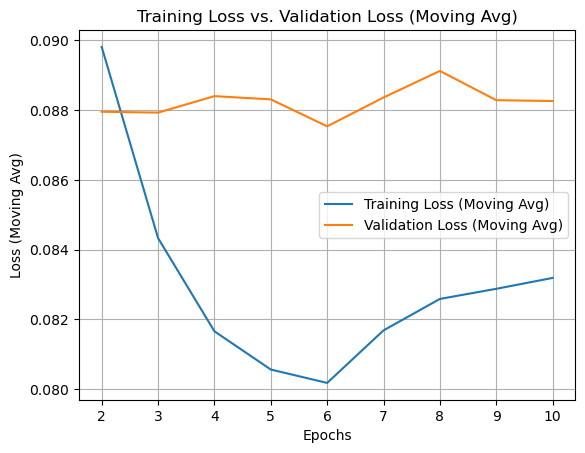

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the training_losses and validation_losses lists from the training process

# Function to calculate moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Set the window size for moving average
window_size = 2

# Calculate moving average of training and validation losses
training_losses_moving_avg = moving_average(training_losses, window_size)
validation_losses_moving_avg = moving_average(validation_losses, window_size)

# Create a list of epochs for the x-axis
epochs = list(range(window_size, num_epochs + 1))

# Plot the moving average of training loss vs. validation loss
plt.plot(epochs, training_losses_moving_avg, label='Training Loss (Moving Avg)')
plt.plot(epochs, validation_losses_moving_avg, label='Validation Loss (Moving Avg)')

plt.xlabel('Epochs')
plt.ylabel('Loss (Moving Avg)')
plt.title('Training Loss vs. Validation Loss (Moving Avg)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
batch_size = 1
train_dataset_tst = tf.data.Dataset.from_tensor_slices((train_low_res_images, train_high_res_images)).shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset_tst = tf.data.Dataset.from_tensor_slices((validation_low_res_images, validation_high_res_images)).shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
esrgan_model.layers[1].save('/kaggle/working/best_esrgan_architecture/')

In [ ]:
new_model = tf.keras.models.load_model('/kaggle/working/best_esrgan_architecture/')

In [ ]:
new_model.load_weights('/kaggle/working/best_esrgan_generator.h5')

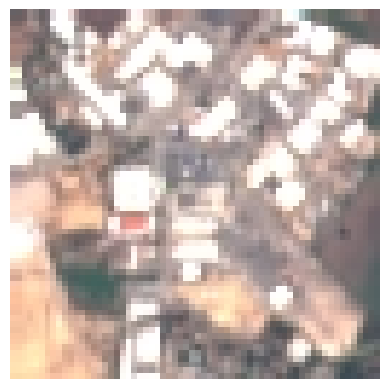

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Specify the image path
image_path = '/kaggle/input/eurosan/2750/Industrial/Industrial_1001.jpg'

# Load the image as a PIL Image object
image_pil = load_img(image_path)

# Convert the PIL Image object to a 64x64x3 image tensor
image_tensor = img_to_array(image_pil)

# Reshape the image tensor to have a batch dimension (optional, if you want to process multiple images at once)
image_tensor = image_tensor.reshape((1,) + image_tensor.shape)

# Now 'image_tensor' is a 64x64x3 image tensor that can be used in TensorFlow models
plt.imshow(image_tensor[0].astype(int))
plt.axis('off')
plt.show()

In [ ]:
hrImage = load_high_res_image('/kaggle/input/eurosan/2750/Industrial/Industrial_1001.jpg')


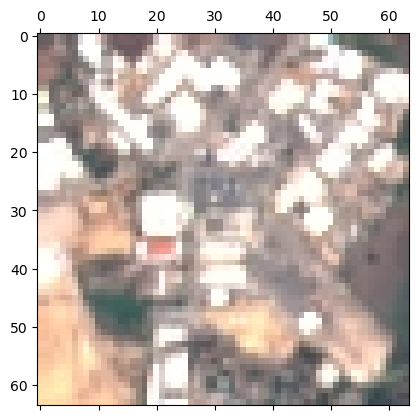

In [ ]:
plt.matshow(hrImage)

In [ ]:
#newImage = new_model(hrImage)

newTestImage = np.zeros(shape = (1,64,64,3),dtype = np.float32)
newTestImage[0] = hrImage
newImage = new_model(newTestImage)

In [ ]:
newImage[0]

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[4.40953073e-07, 3.61983618e-03, 3.64294445e-17],
        [2.54956722e-01, 1.00000000e+00, 2.71337301e-01],
        [2.68921517e-02, 1.00385572e-03, 0.00000000e+00],
        ...,
        [5.07416783e-19, 1.00000000e+00, 1.62526248e-09],
        [1.00000000e+00, 4.51234064e-06, 1.04678783e-31],
        [4.75402573e-20, 1.00000000e+00, 1.32190604e-13]],

       [[0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [0.00000000e+00, 1.00000000e+00, 2.03581749e-05],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        ...,
        [0.00000000e+00, 4.70282835e-08, 0.00000000e+00],
        [0.00000000e+00, 7.50944937e-24, 1.00000000e+00],
        [0.00000000e+00, 5.62506957e-16, 0.00000000e+00]],

       [[5.75997638e-10, 3.44301443e-05, 0.00000000e+00],
        [2.45676729e-10, 1.00000000e+00, 2.62969825e-05],
        [8.97098585e-13, 2.61011814e-06, 0.00000000e+00],
        ...,
        [0.00000000e+00, 1.00000